In [2]:
import subprocess 
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.distributions import Uniform, Laplace
from torch.distributions.multivariate_normal import MultivariateNormal
import pandas as pd
import numpy as np
import csv
import json
from cox.utils import Parameters
from cox.store import Store

from cox.readers import CollectionReader
import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import math 

import sys 
sys.path.append('../..')
from delphi.stats.linear_regression import TruncatedRegression
from delphi import oracle
from delphi.utils import constants as consts
from delphi.utils.helpers import setup_store_with_metadata

OUT_DIR = '/home/gridsan/stefanou/Regression/'
TABLE_NAME = 'logs'

# set environment variable so that stores can create output files
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

In [42]:
args = Parameters({
    "bias": True,
    "samples": 10000,
    "c": 0,
    "batch_size": 5,
    "lr": 1e-1,
    "var_lr": 1e-2,
    "var_": 1,
    "trials": 3,
    "norm": False,
    "workers": 8,
    "steps": 1000,
    "x_lower": -10,
    "x_upper": 10,
    "lower": -1,
    "upper": 1,
    "device": "cuda",
    "num_samples": 100,
})
mse_loss = ch.nn.MSELoss()

I will start by generating the ground-truth for our expriment.

gt weight:  Parameter containing:
tensor([[1.]], requires_grad=True)
gt bias:  Parameter containing:
tensor([[1.]], requires_grad=True)
alpha:  tensor([0.4550])
gt ols coef:  [[1.0049922]]
gt ols intercept:  [0.98592526]
trunc ols coef:  [[0.5880828]]
trunc ols intercept:  [-0.14741492]


Text(0, 0.5, 'y')

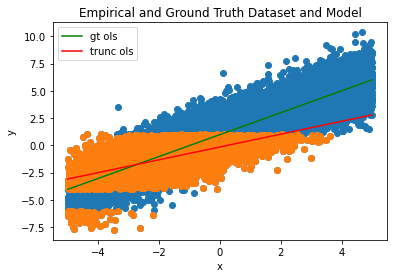

In [73]:
# distribution for generating feature vectors
d, k = 1, 1
# w = Uniform(-1, 1)
# m = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
m = Uniform(-5, 5)
# phi = oracle.Identity()
intervals = [(-8, -6), (-4, 1)]
phi = oracle.KIntervalUnion(intervals)

# generate ground truth
gt = ch.nn.Linear(in_features=k, out_features=1)
gt.weight = ch.nn.Parameter(ch.ones(k, d))

# gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
print("gt weight: ", gt.weight)
print("gt bias: ", gt.bias)

# create base classifier
with ch.no_grad():
    # generate data
    X = m.sample(ch.Size([args.samples, d])) if isinstance(m, Uniform) else m.sample(ch.Size([args.samples]))
    y = gt(X)

noise_var = Tensor([2.0])[...,None]
# remove synthetic data from the computation graph
with ch.no_grad():
    # add noise to ground-truth pedictions
    noised = y + ch.sqrt(noise_var) * ch.randn(X.size(0), 1)
    # truncate based off of the standardized data
    indices = phi(noised).flatten().nonzero(as_tuple=False).flatten()
    y_trunc, x_trunc = noised[indices], X[indices]
    alpha = Tensor([y_trunc.size(0) / args.samples])
    print("alpha: ", alpha)
    
# ground-truth OLS
gt_ols = LinearRegression()
gt_ols.fit(X, noised)
print("gt ols coef: ", gt_ols.coef_)
print("gt ols intercept: ", gt_ols.intercept_)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc)
trunc_ols_pred = trunc_ols.predict(x_trunc)
print("trunc ols coef: ", trunc_ols.coef_)
print("trunc ols intercept: ", trunc_ols.intercept_)

# data for plotting regressions
unnorm_data = np.linspace(-5, 5, 100).reshape(100, 1)
norm_data = np.linspace(-1, 1, 100).reshape(100, 1)

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt ols')
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Empirical and Ground Truth Dataset and Model")
ax.set_xlabel("x")
ax.set_ylabel("y")

Now, we want to standardize our truncated dataset, so that our empirical estimates are located on the l2 ball. First we will divide all of our covariate features by $B\sqrt{k}$, so that all of our covariate features $||x_{i}||_{2}^{2} \leq 1$, and reside on the $\ell_{2}$ ball. This way the norm of $w$ will be multiplied by $B\sqrt{k}$.

In [74]:
max_x_trunc_norm = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()
print("max truncated x norm", max_x_trunc_norm)

beta = max_x_trunc_norm*math.sqrt(X.size(1))
print("beta: ", beta)

x_trunc_norm = x_trunc / beta
print("x max l2: ", x_trunc_norm.norm(dim=-1).max())

max truncated x norm tensor(4.9999)
beta:  tensor(4.9999)
x max l2:  tensor(1.)


We now observe that the norm of the truncated x covariates is bounded by 1. So, now we will standardze our dependent variable so that it's ground-truth takes the form of the linear regression latent variable model with noise variance of 1. First, let's calculate the predicted values from our naive ols regression on the truncated data.

First, we will standardize our data for the case where we assume that the empirical noise variance is the underlying noise variance of the ground truth regression.

emp noise var:  tensor([1.3424])
trunc reg noise var:  tensor([1.])


Text(0, 0.5, 'y')

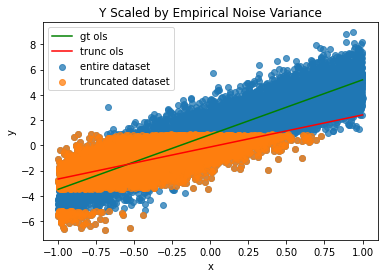

In [75]:
emp_noise_var = (y_trunc - trunc_ols_pred).var(0)
print("emp noise var: ", emp_noise_var)

emp_stand_intervals = [(int_[0]/emp_noise_var, int_[1]/emp_noise_var) for int_ in intervals]
emp_scaled_kinterval = oracle.KIntervalUnion(emp_stand_intervals)

emp_stand_y_trunc = y_trunc / ch.sqrt(emp_noise_var)
trunc_noise_var = (emp_stand_y_trunc - (trunc_ols_pred / ch.sqrt(emp_noise_var))).var(0)
print("trunc reg noise var: ", trunc_noise_var)

new_X, emp_stand_noised = X / beta, noised / ch.sqrt(emp_noise_var)

gt_emp_stand = LinearRegression()
gt_emp_stand.fit(new_X, emp_stand_noised)

trunc_emp_stand_ols = LinearRegression()
trunc_emp_stand_ols.fit(x_trunc_norm, emp_stand_y_trunc)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title('Y Scaled by Empirical Noise Variance')
ax.set_xlabel("x")
ax.set_ylabel("y")

First, we will standardize our data for the case where we assume that wee know the underlying ground-truth noise variance.

trunc reg noise var:  tensor([0.6712])
reg noise var:  tensor([1.0127])


Text(0, 0.5, 'y')

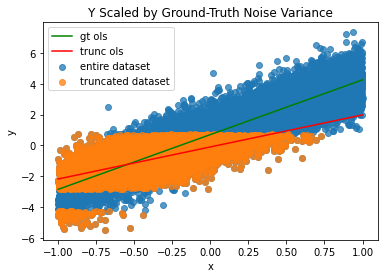

In [76]:
stand_noised, stand_y_trunc = noised / ch.sqrt(noise_var), y_trunc / ch.sqrt(noise_var)
stand_intervals = [(int_[0]/float(ch.sqrt(noise_var)), int_[1]/float(ch.sqrt(noise_var))) for int_ in intervals]
scaled_kinterval = oracle.KIntervalUnion(stand_intervals)

gt_stand = LinearRegression()
gt_stand.fit(new_X, stand_noised)

trunc_stand_ols = LinearRegression()
trunc_stand_ols.fit(x_trunc_norm, stand_y_trunc)

trunc_noise_var = (stand_y_trunc - trunc_stand_ols.predict(x_trunc_norm)).var(0)
print("trunc reg noise var: ", trunc_noise_var)

reg_noise_var = (stand_noised - gt_stand.predict(new_X)).var(0)
print("reg noise var: ", reg_noise_var)

ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt ols')
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='red', label='trunc ols')
plt.legend()
plt.title("Y Scaled by Ground-Truth Noise Variance")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Empirical Variance

In [77]:
trunc_reg = TruncatedRegression(phi=emp_scaled_kinterval, alpha=alpha, bias=True, unknown=False, val=100, bs=10, n=100, tol=1e-2)
known_emp_res = trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
known_emp_w_unnorm = (known_emp_res.weight * ch.sqrt(emp_noise_var)) / beta

known_emp_bias_unnorm = ch.zeros(1, 1)
if args.bias: 
    known_emp_bias_unnorm = (known_emp_res.bias * ch.sqrt(emp_noise_var))

0 steps | score: [0.24450238049030304]
100 steps | score: [0.2522695064544678]
200 steps | score: [0.14247821271419525]
300 steps | score: [0.20084036886692047]
400 steps | score: [0.29707247018814087]
500 steps | score: [0.183303564786911]
600 steps | score: [0.2556333541870117]
700 steps | score: [0.1396505981683731]
800 steps | score: [0.31877315044403076]
900 steps | score: [0.20486092567443848]
1000 steps | score: [0.1938360631465912]
1100 steps | score: [0.22274009883403778]
1200 steps | score: [0.23887240886688232]
1300 steps | score: [0.27861475944519043]


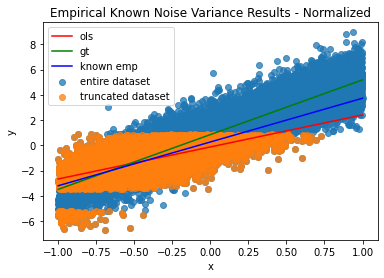

Text(0, 0.5, 'y')

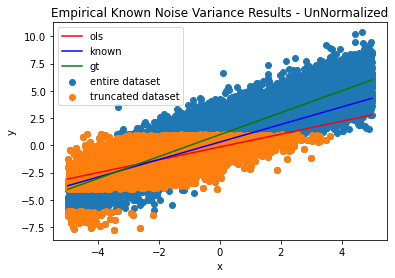

In [78]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_emp_res(Tensor(norm_data)).detach().numpy(), label='known emp', color='blue')
plt.legend()
plt.title("Empirical Known Noise Variance Results - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='red', label='ols')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_emp_w_unnorm + known_emp_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.scatter(X, noised, label='entire dataset')
plt.scatter(x_trunc, y_trunc, label='truncated dataset')
plt.legend()
plt.title("Empirical Known Noise Variance Results - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")

Truncated Regression with Known Variance

In [79]:
trunc_reg = TruncatedRegression(phi=scaled_kinterval, alpha=alpha, bias=args.bias, unknown=False, val=100, bs=10, n=100, tol=1e-2, steps=2500)
known_res = trunc_reg.fit(x_trunc_norm, stand_y_trunc)
known_weight_unnorm = (known_res.weight * ch.sqrt(noise_var)) / beta

known_bias_unnorm = ch.zeros(1, 1)
if args.bias:  
    known_bias_unnorm = known_res.bias * ch.sqrt(noise_var)

0 steps | score: [-0.08650511503219604]
100 steps | score: [-0.04581739753484726]
200 steps | score: [-0.1050160601735115]
300 steps | score: [-0.09050310403108597]
400 steps | score: [0.015834834426641464]
500 steps | score: [-0.09193232655525208]
600 steps | score: [-0.012469545006752014]
700 steps | score: [-0.102044016122818]
800 steps | score: [0.012199152261018753]
900 steps | score: [-0.06101793795824051]
1000 steps | score: [-0.08049361407756805]
1100 steps | score: [-0.04175977036356926]
1200 steps | score: [-0.03605726361274719]
1300 steps | score: [0.006995882838964462]


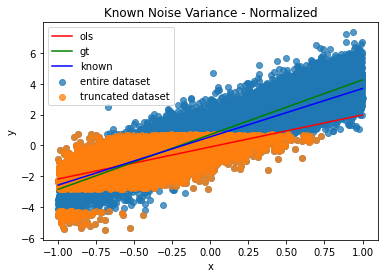

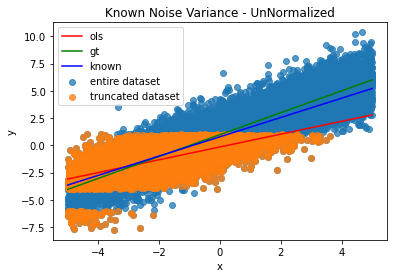

In [80]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, known_res(Tensor(norm_data)).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), color='r', label='ols')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='green', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@known_weight_unnorm + known_bias_unnorm).detach().numpy(), label='known', color='blue')
plt.legend()
plt.title("Known Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

Truncated Regression with Unknown Noise Variance

In [81]:
trunc_reg = TruncatedRegression(phi=emp_scaled_kinterval, alpha=alpha, bias=True, unknown=True, bs=10, n=100, tol=1e-2, val=100, steps=2000)
unknown_res = trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)
unknown_var = unknown_res.lambda_.inverse()
unknown_weight_unnorm, unknown_bias_unnorm = (((unknown_res.weight * unknown_var) * ch.sqrt(emp_noise_var)) / beta).detach().numpy(), ((unknown_res.bias * unknown_var) * ch.sqrt(emp_noise_var)).detach().numpy()

0 steps | score: [-0.1568070352077484, 0.08321969211101532]
100 steps | score: [-0.048823095858097076, 0.006759066134691238]
200 steps | score: [-0.3318922817707062, -0.7452709078788757]
300 steps | score: [-0.30775973200798035, -0.6020576357841492]
400 steps | score: [-0.21123218536376953, -0.4622640609741211]
500 steps | score: [-0.16567757725715637, -0.276089608669281]
600 steps | score: [-0.1283351331949234, -0.22076290845870972]
700 steps | score: [-0.2728740870952606, -0.5913558602333069]
800 steps | score: [-0.04879714176058769, -0.01451406255364418]
900 steps | score: [-0.13640156388282776, -0.2577878534793854]
1000 steps | score: [-0.1838807910680771, -0.3610472083091736]
1100 steps | score: [-0.08731968700885773, -0.0714782327413559]
1200 steps | score: [-0.021591393277049065, 0.05796915292739868]
1300 steps | score: [-0.047581370919942856, -0.06651917845010757]
1400 steps | score: [-0.17746832966804504, -0.3190794289112091]
1500 steps | score: [0.004769529215991497, 0.073676

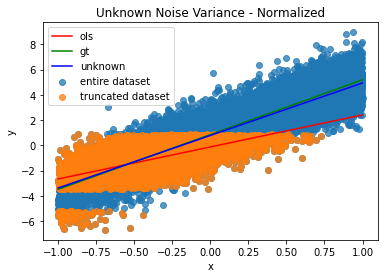

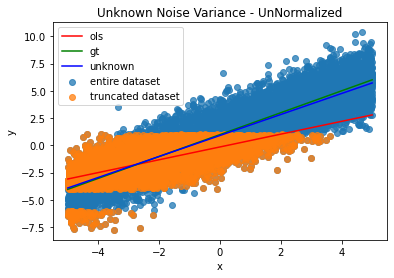

In [82]:
ax = plt.subplot(1, 1, 1)
plt.scatter(new_X, emp_stand_noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc_norm, emp_stand_y_trunc, label='truncated dataset', alpha=.75)
plt.plot(norm_data, trunc_emp_stand_ols.predict(norm_data), color='r', label='ols')
plt.plot(norm_data, gt_emp_stand.predict(norm_data), color='green', label='gt')
plt.plot(norm_data, unknown_res(Tensor(norm_data)).detach().numpy(), label='unknown', color='blue')
plt.legend()
ax.set_title("Unknown Noise Variance - Normalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

ax = plt.subplot(1, 1, 1)
plt.scatter(X, noised, label='entire dataset', alpha=.75)
plt.scatter(x_trunc, y_trunc, label='truncated dataset', alpha=.75)
plt.plot(unnorm_data, trunc_ols.predict(unnorm_data), label='ols', color='red')
plt.plot(unnorm_data, gt_ols.predict(unnorm_data), color='g', label='gt')
plt.plot(unnorm_data, (Tensor(unnorm_data)@unknown_weight_unnorm + unknown_bias_unnorm), color='blue', label='unknown')
plt.legend()
ax.set_title("Unknown Noise Variance - UnNormalized")
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.show()

# Truncate at Zero and Run for High Variance

In [121]:
args.__setattr__('bs', 10)
args.__setattr__('steps', 2500)
args.__setattr__('step_lr', 100)
args.__setattr__('step_lr_gamma', .9)
args.__setattr__('tol', 1e-2)
args.__setattr__('trials', 5)
args.__setattr__('samples', 1000)

EXP = 'KIntervalUnionNoiseVar5.0'

In [122]:
 # expriment parameters
w_lower, w_upper = -1, 1
d, k = 1, 1

# distribution for generating feature vectors
dist = MultivariateNormal(ch.zeros(d), ch.eye(d)/d)
samples = [100, 500, 1000, 1500, 2000, 2500, 5000]
intervals = [(-8, -6), (-4, 1), (2, 4)]
phi = oracle.KIntervalUnion(intervals)
noise_var = Tensor([5.0])

stand_intervals = [(int_[0]/float(ch.sqrt(noise_var)), int_[1]/float(ch.sqrt(noise_var))) for int_ in intervals]
scaled_kinterval = oracle.KIntervalUnion(stand_intervals)

for i in range(args.trials):
    # create store and add table
    store = Store(OUT_DIR + EXP)
    store.add_table(TABLE_NAME, { 
        'ols_r2': float,
        'ols_param_mse': float,
        'ols_var_l1': float,
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'unknown_r2': float, 
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_time': int,
        'alpha': float, 
        'num_samples': int,
        'noise_scale': float, 
    })


    # generate ground truth
    gt = ch.nn.Linear(in_features=d, out_features=k)
    gt.weight = ch.nn.Parameter(ch.ones(k, d))
    gt.bias = ch.nn.Parameter(ch.ones(1, 1)) if args.bias else None
    
    for s in samples: 
        X, noised = Tensor([]), Tensor([])
        x_trunc, y_trunc = Tensor([]), Tensor([])
        
        # generate data until s number of samples fall within the truncation set
        with ch.no_grad():
            while x_trunc.size(0) < s: 
                x_ = dist.sample(ch.Size([args.samples]))
                new_noised = gt(x_) + ch.sqrt(noise_var) * ch.randn(args.samples, 1)
                # add noise to ground-truth pedictions
                # truncate based off of the standardized data
                indices = phi(new_noised).flatten().nonzero(as_tuple=False).flatten()
                y_trunc, x_trunc = ch.cat([y_trunc, new_noised[indices]]), ch.cat([x_trunc, x_[indices]])
                X, noised = ch.cat([X, x_]), ch.cat([noised, new_noised])
        x_trunc, y_trunc = x_trunc[:s], y_trunc[:s]
        alpha = Tensor([y_trunc.size(0) / noised.size(0)])
        
        # normalize x features so that ||x_{i}||_{2}^{2} <= 1
        l_inf = LA.norm(x_trunc, dim=-1, ord=float('inf')).max() # find max l_inf
        # calculate normalizing constant
        beta = l_inf*math.sqrt(d)
        """
        Divide input features by normalizing constant. By doing so, 
        the weights will be increased by a magnitude of beta.
        """
        x_trunc_norm = x_trunc / beta
         # normalize entire dataset by beta
        x_norm = X / beta
        
        # ground-truth ols
        gt_ols = LinearRegression()
        gt_ols.fit(X, noised)
        gt_params = ch.cat([Tensor(gt_ols.coef_).T, Tensor(gt_ols.intercept_)[..., None]]).flatten()
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        ols_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[..., None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        # check r2 for entire dataset
        ols_pred = ols.predict(X)

        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(noised.flatten(), ols_pred.flatten()), 
            'ols_var_l1': ch.abs(ols_var - ch.ones(1)),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })
        
        """
        Run dataset on truncated regression with known variance, while 
        assuming that the empirical noise variance is the underlying noise 
        variance of our linear regression. This means that we want to standardize 
        our dependent variable by the empirical noise variance. 
        """
        # variance of the residuals
        emp_noise_var = (y_trunc - ols.predict(x_trunc_norm)).var(0)
        emp_stand_intervals = [(int_[0]/math.sqrt(float(emp_noise_var)), int_[1]/math.sqrt(float(emp_noise_var))) for int_ in intervals]
        emp_scaled_kinterval = oracle.KIntervalUnion(emp_stand_intervals)
        # standardize y trunc by the empirical noise variance
        emp_stand_y_trunc = y_trunc / ch.sqrt(emp_noise_var)        
        
        """
        Run dataset on truncated regression with known variance. This means that we want to standardize 
        our dependent variable by the true noise variance. 
        """
        # standardize y trunc by actual noise variance
        stand_y_trunc = y_trunc / ch.sqrt(noise_var)
        # standardize noised by actual noise variance
        stand_noised = noised / ch.sqrt(noise_var)
        trunc_reg = trunc_reg = TruncatedRegression(phi=scaled_kinterval, alpha=alpha, bias=args.bias, unknown=False, bs=args.bs, n=100, tol=args.tol, steps=args.steps)
        st = datetime.datetime.now()
        known_results = trunc_reg.fit(x_trunc_norm, stand_y_trunc)
        w, w0 = (known_results.weight.detach().cpu() * math.sqrt(ch.ones(1))) / beta, known_results.bias.detach().cpu()[..., None] * math.sqrt(ch.ones(1))
        known_params = ch.cat([w, w0], dim=1).flatten()
        # known results
        store[TABLE_NAME].update_row({
            'known_r2': r2_score(noised.flatten(), X@w.T + w0), 
            'known_param_mse': mse_loss(known_params, gt_params),
            'known_time': int((datetime.datetime.now() - st).total_seconds()), 
        })
        
        
        # truncated regression with unknown variance
        trunc_reg = TruncatedRegression(phi=emp_scaled_kinterval, alpha=alpha, bias=args.bias, unknown=True, bs=args.bs, n=100, tol=args.tol, steps=args.steps)
        st = datetime.datetime.now()
        unknown_results = trunc_reg.fit(x_trunc_norm, emp_stand_y_trunc)

        var_ = unknown_results.lambda_.inverse()
        unknown_var = var_ * emp_noise_var
        w, w0 = (((unknown_results.weight * var_) * ch.sqrt(emp_noise_var)) / beta).detach(), ((unknown_results.bias * ch.sqrt(emp_noise_var))).detach()[None,...]
        unknown_params = ch.cat([w, w0], dim=1).flatten()

        # known emp results
        store[TABLE_NAME].update_row({
            'unknown_r2': r2_score(noised.flatten(), X@w.T + w0), 
            'unknown_param_mse': mse_loss(unknown_params, gt_params),
            'unknown_var_l1': float(ch.abs(unknown_var - ch.ones(1))),
            'unknown_time': int((datetime.datetime.now() - st).total_seconds()), 
        })
        
        
        # add additional exp data to store
        store[TABLE_NAME].update_row({ 
            'alpha': float(alpha.flatten()),
            'num_samples': x_trunc.size(0),
            'noise_scale': noise_var, 
        })

        # append row to table
        store[TABLE_NAME].flush_row()
    store.close()    

Logging in: /home/gridsan/stefanou/Regression/KIntervalUnionNoiseVar5.0/b644295e-a1d9-49d5-9562-85fc09eaa810
0 steps | score: [-0.15469509363174438]
100 steps | score: [-0.014863645657896996]
200 steps | score: [-0.017655713483691216]
300 steps | score: [0.003819277510046959]
0 steps | score: [0.1323433369398117, 0.04441211372613907]
100 steps | score: [0.11266674101352692, -0.03911559283733368]
200 steps | score: [0.10926435142755508, -0.04829452559351921]
300 steps | score: [0.14490343630313873, -0.044181182980537415]
400 steps | score: [0.15196827054023743, -0.05596023052930832]
500 steps | score: [0.1260530799627304, -0.04569292441010475]
600 steps | score: [0.11125705391168594, -0.049169741570949554]
700 steps | score: [0.09801986813545227, -0.03551945090293884]
800 steps | score: [0.1161271259188652, -0.0455937497317791]
900 steps | score: [0.09700268507003784, -0.032755590975284576]
1000 steps | score: [0.11449997872114182, -0.049950387328863144]
1100 steps | score: [0.096484661

1700 steps | score: [0.22074274718761444, -0.1126689463853836]
1800 steps | score: [0.14241178333759308, -0.08875909447669983]
1900 steps | score: [0.15299305319786072, -0.10011947154998779]
2000 steps | score: [0.1660834550857544, -0.09145837277173996]
2100 steps | score: [0.14077654480934143, -0.08276203274726868]
2200 steps | score: [0.09615586698055267, -0.09284032881259918]
2300 steps | score: [0.13755321502685547, -0.09589996933937073]
2400 steps | score: [0.09757592529058456, -0.05735558643937111]
2500 steps | score: [0.10260427743196487, -0.07868963479995728]
0 steps | score: [-0.1894298791885376]
100 steps | score: [-0.03310325741767883]
200 steps | score: [-0.005083426833152771]
0 steps | score: [-0.26263856887817383, 0.14690497517585754]
100 steps | score: [-0.15055571496486664, 0.06831065565347672]
200 steps | score: [-0.05197271704673767, 0.0352657288312912]
300 steps | score: [-0.13104651868343353, 0.050273872911930084]
400 steps | score: [-0.058977775275707245, 0.0477517

800 steps | score: [-0.11696416884660721]
900 steps | score: [-0.1339036077260971]
1000 steps | score: [-0.13077986240386963]
1100 steps | score: [-0.1220499724149704]
1200 steps | score: [-0.11948257684707642]
1300 steps | score: [-0.1362997442483902]
1400 steps | score: [-0.1517811268568039]
1500 steps | score: [-0.14338672161102295]
1600 steps | score: [-0.14579619467258453]
1700 steps | score: [-0.14640018343925476]
1800 steps | score: [-0.15573103725910187]
1900 steps | score: [-0.1138496845960617]
2000 steps | score: [-0.13407911360263824]
2100 steps | score: [-0.11419082432985306]
2200 steps | score: [-0.12871932983398438]
2300 steps | score: [-0.10459263622760773]
2400 steps | score: [-0.14406388998031616]
2500 steps | score: [-0.1438802182674408]
0 steps | score: [-0.05480637401342392, 0.039862945675849915]
100 steps | score: [0.1004229262471199, -0.03300878033041954]
200 steps | score: [0.0876474529504776, -0.04270688816905022]
300 steps | score: [0.07512003928422928, -0.0352

700 steps | score: [-0.12932632863521576]
800 steps | score: [-0.11937977373600006]
900 steps | score: [-0.12290450930595398]
1000 steps | score: [-0.11932960152626038]
1100 steps | score: [-0.1036001443862915]
1200 steps | score: [-0.1117667481303215]
1300 steps | score: [-0.13648751378059387]
1400 steps | score: [-0.11359861493110657]
1500 steps | score: [-0.1157563328742981]
1600 steps | score: [-0.13576674461364746]
1700 steps | score: [-0.09665622562170029]
1800 steps | score: [-0.10974244028329849]
1900 steps | score: [-0.12385762482881546]
2000 steps | score: [-0.12238088995218277]
2100 steps | score: [-0.12950944900512695]
2200 steps | score: [-0.09901368618011475]
2300 steps | score: [-0.07977215200662613]
2400 steps | score: [-0.09199424088001251]
2500 steps | score: [-0.0876946896314621]
0 steps | score: [-0.2716742753982544, 0.09519977122545242]
100 steps | score: [-0.12091922014951706, -0.010902578011155128]
200 steps | score: [-0.16081677377223969, -0.005025956779718399]


700 steps | score: [0.24415898323059082]
800 steps | score: [0.09190002083778381]
900 steps | score: [0.1718723326921463]
1000 steps | score: [0.12479165196418762]
1100 steps | score: [0.12040575593709946]
1200 steps | score: [0.20857806503772736]
1300 steps | score: [0.09126725792884827]
1400 steps | score: [0.13735976815223694]
1500 steps | score: [0.1485782414674759]
1600 steps | score: [0.11684023588895798]
1700 steps | score: [0.1614946573972702]
1800 steps | score: [0.12304309010505676]
1900 steps | score: [0.10200624912977219]
2000 steps | score: [0.1131981685757637]
2100 steps | score: [0.08393116295337677]
2200 steps | score: [0.1109628975391388]
2300 steps | score: [0.056892797350883484]
2400 steps | score: [0.08198706805706024]
2500 steps | score: [0.09769980609416962]
0 steps | score: [-0.18467707931995392, 0.032113172113895416]
100 steps | score: [0.004861436318606138, -0.07094405591487885]
200 steps | score: [0.09715266525745392, -0.12986299395561218]
300 steps | score: [

700 steps | score: [0.01308219414204359, -0.06384683400392532]
800 steps | score: [-0.006163442973047495, -0.08078855276107788]
900 steps | score: [0.021349171176552773, -0.07026788592338562]
1000 steps | score: [-0.004829224664717913, -0.076878122985363]
1100 steps | score: [0.02628457546234131, -0.05600881576538086]
1200 steps | score: [0.034801580011844635, -0.08644042909145355]
1300 steps | score: [0.0067400746047496796, -0.07552927732467651]
1400 steps | score: [0.0009099197341129184, -0.056937091052532196]
1500 steps | score: [-0.012342533096671104, -0.07027392089366913]
1600 steps | score: [-0.030432753264904022, -0.06755872070789337]
1700 steps | score: [-0.0020332338754087687, -0.07835954427719116]
1800 steps | score: [0.0018933917162939906, -0.07416430860757828]
1900 steps | score: [0.004474231507629156, -0.0781460702419281]
2000 steps | score: [-0.027347834780812263, -0.06739498674869537]
2100 steps | score: [-0.02435486577451229, -0.05239185318350792]
2200 steps | score: [-

100 steps | score: [0.08352429419755936]
200 steps | score: [0.02701392211019993]
300 steps | score: [-0.05690866336226463]
400 steps | score: [0.0008584447205066681]
0 steps | score: [-0.006786698009818792, -0.03406619280576706]
100 steps | score: [0.191210076212883, -0.1329672485589981]
200 steps | score: [0.19599881768226624, -0.1320994645357132]
300 steps | score: [0.0981387123465538, -0.11155648529529572]
400 steps | score: [0.09361312538385391, -0.1575755476951599]
500 steps | score: [0.08082647621631622, -0.14216916263103485]
600 steps | score: [0.19143643975257874, -0.14032690227031708]
700 steps | score: [0.17262479662895203, -0.11433492600917816]
800 steps | score: [0.11037509888410568, -0.10338228940963745]
900 steps | score: [0.1458178162574768, -0.15526704490184784]
1000 steps | score: [0.07768717408180237, -0.11823935061693192]
1100 steps | score: [0.18757346272468567, -0.11900164186954498]
1200 steps | score: [0.12777818739414215, -0.09269972145557404]
1300 steps | score

2100 steps | score: [0.11121463775634766]
2200 steps | score: [0.17658337950706482]
2300 steps | score: [0.10834866762161255]
2400 steps | score: [0.12892211973667145]
2500 steps | score: [0.08550241589546204]
0 steps | score: [-0.2861984074115753, 0.06835608929395676]
100 steps | score: [-0.043413061648607254, -0.02701639011502266]
200 steps | score: [-0.029771870002150536, -0.04850268363952637]
300 steps | score: [-0.009993110783398151, -0.06259126961231232]
400 steps | score: [-0.039785344153642654, -0.04444398358464241]
500 steps | score: [-0.029777176678180695, -0.05499638617038727]
600 steps | score: [-0.057307153940200806, -0.0498795211315155]
700 steps | score: [-0.025512857362627983, -0.05935515835881233]
800 steps | score: [-0.04999770596623421, -0.04020348936319351]
900 steps | score: [-0.031857624650001526, -0.03846155107021332]
1000 steps | score: [-0.06096172705292702, -0.04306977614760399]
1100 steps | score: [-0.07457403838634491, -0.05050075054168701]
1200 steps | scor

600 steps | score: [-0.20306970179080963, 0.028211701661348343]
700 steps | score: [-0.183488130569458, 0.019828371703624725]
800 steps | score: [-0.1590014547109604, 0.03762737661600113]
900 steps | score: [-0.21826113760471344, 0.04185871779918671]
1000 steps | score: [-0.2021600902080536, 0.03683129698038101]
1100 steps | score: [-0.21968071162700653, 0.032490022480487823]
1200 steps | score: [-0.18095773458480835, 0.009408365935087204]
1300 steps | score: [-0.156515970826149, 0.01552417129278183]
1400 steps | score: [-0.19027936458587646, 0.008216194808483124]
1500 steps | score: [-0.19921712577342987, 0.05161132663488388]
1600 steps | score: [-0.18786868453025818, 0.022802136838436127]
1700 steps | score: [-0.18472833931446075, -0.0109170600771904]
1800 steps | score: [-0.1820865422487259, 0.004453331232070923]
1900 steps | score: [-0.1907297819852829, 0.012922924011945724]
2000 steps | score: [-0.16957861185073853, 0.01061534509062767]
2100 steps | score: [-0.1702650487422943, -0

500 steps | score: [-0.06564048677682877, 0.0015259236097335815]
600 steps | score: [-0.08569487929344177, 0.0005311295390129089]
700 steps | score: [-0.06379817426204681, 0.006914946250617504]
800 steps | score: [-0.07304906845092773, -0.011657517403364182]
900 steps | score: [-0.06595152616500854, -0.004763051867485046]
1000 steps | score: [-0.07462464272975922, -0.004343893378973007]
1100 steps | score: [-0.06662272661924362, 0.0052889492362737656]
1200 steps | score: [-0.08102628588676453, 0.007673727348446846]
1300 steps | score: [-0.05605914071202278, -0.01435907557606697]
1400 steps | score: [-0.05982144549489021, -0.0012232093140482903]
1500 steps | score: [-0.07441843301057816, -0.010194465517997742]
1600 steps | score: [-0.07016918063163757, -0.01081356592476368]
1700 steps | score: [-0.07626958936452866, -0.005708012729883194]
1800 steps | score: [-0.07734004408121109, -0.006820168346166611]
1900 steps | score: [-0.05903085693717003, -0.0032203271985054016]
2000 steps | scor

400 steps | score: [-0.3213724195957184, 0.03021484613418579]
500 steps | score: [-0.26046988368034363, 0.01956859417259693]
600 steps | score: [-0.23218315839767456, 0.03363241255283356]
700 steps | score: [-0.1911996304988861, 0.0021761078387498856]
800 steps | score: [-0.23971833288669586, 0.045684367418289185]
900 steps | score: [-0.363066703081131, 0.04853658005595207]
1000 steps | score: [-0.24466104805469513, 0.014655668288469315]
1100 steps | score: [-0.24222372472286224, 0.028464848175644875]
1200 steps | score: [-0.1928454488515854, 0.008493614383041859]
1300 steps | score: [-0.22206853330135345, 0.018415242433547974]
1400 steps | score: [-0.27214938402175903, 0.02888035774230957]
1500 steps | score: [-0.20359079539775848, 0.014837914146482944]
1600 steps | score: [-0.26171591877937317, 0.026201482862234116]
1700 steps | score: [-0.1989213079214096, -0.00017677340656518936]
1800 steps | score: [-0.23428864777088165, 0.04101533442735672]
1900 steps | score: [-0.258220076560974

In [123]:
# store.close()
reader = CollectionReader(OUT_DIR + EXP)
logs = reader.df(TABLE_NAME)
reader.close()
logs.head()

100%|██████████| 5/5 [00:00<00:00, 198.97it/s]


,ols_r2,ols_param_mse,ols_var_l1,known_r2,known_param_mse,known_time,unknown_r2,unknown_param_mse,unknown_var_l1,unknown_time,alpha,num_samples,noise_scale,exp_id
0,0.111978,0.225103,3.277951,0.070711,0.352548,0,0.112250,0.213383,5.838987,3,0.100000,100,5.0,2e0a6b7c-11bc-4ef4-9e95-51c55343ebbf
1,0.122611,0.119299,2.504785,0.063448,0.305837,2,0.160296,0.002297,3.624043,3,0.500000,500,5.0,2e0a6b7c-11bc-4ef4-9e95-51c55343ebbf
2,0.107089,0.150944,2.871558,0.056623,0.292121,1,0.155930,0.013339,3.890105,3,0.500000,1000,5.0,2e0a6b7c-11bc-4ef4-9e95-51c55343ebbf
3,0.093052,0.151426,2.571354,0.054760,0.261755,1,0.144913,0.002683,3.731856,3,0.500000,1500,5.0,2e0a6b7c-11bc-4ef4-9e95-51c55343ebbf
4,0.106008,0.162472,2.763458,0.025060,0.408356,0,0.156390,0.009428,4.350984,3,0.666667,2000,5.0,2e0a6b7c-11bc-4ef4-9e95-51c55343ebbf


In [124]:
logs[['unknown_param_mse', 'known_param_mse', 'num_samples']]

,unknown_param_mse,known_param_mse,num_samples
0,0.213383,0.352548,100
1,0.002297,0.305837,500
2,0.013339,0.292121,1000
3,0.002683,0.261755,1500
4,0.009428,0.408356,2000
5,0.077400,0.554952,2500
6,0.156849,0.346460,5000
0,0.083833,0.177187,100
1,0.001251,0.289459,500
2,0.005886,0.532712,1000


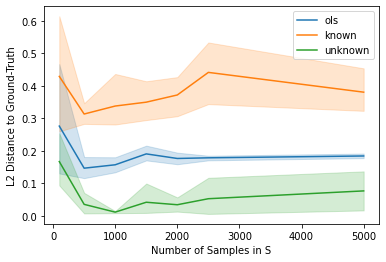

[Text(0.5, 0, 'Number of Samples in S'),
 Text(0, 0.5, 'L1 Distance to Ground-Truth')]

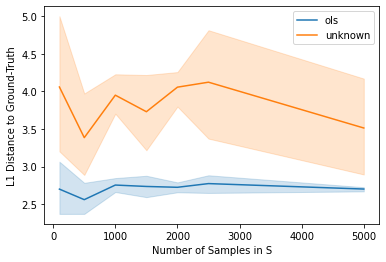

In [125]:
sns.lineplot(data=logs, x='num_samples', y='ols_param_mse', label='ols')
# sns.lineplot(data=logs, x='noise_scale', y='known_emp_param_mse', label='known emp')
ax = sns.lineplot(data=logs, x='num_samples', y='known_param_mse', label='known')
ax = sns.lineplot(data=logs, x='num_samples', y='unknown_param_mse', label='unknown')
ax.set(xlabel='Number of Samples in S', ylabel='L2 Distance to Ground-Truth')
plt.show()

sns.lineplot(data=logs, x='num_samples', y='ols_var_l1', label='ols')
ax = sns.lineplot(data=logs, x='num_samples', y='unknown_var_l1', label='unknown')
ax.set(xlabel='Number of Samples in S', ylabel='L1 Distance to Ground-Truth')

In [128]:
(scaled_kinterval(stand_y_trunc) != 1).nonzero(as_tuple=False)

tensor([], size=(0, 2), dtype=torch.int64)

In [142]:
ols_var

tensor([[6.6700]])

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
# data = ch.from_numpy(np.linspace(-3.0, 3.0, 100)).unsqueeze(1).float()

ax.scatter3D(X[indices][:,0], X[indices][:,1], noised[indices], color="green", alpha=.1)
ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color="red", alpha=.75)

ax.view_init(10, -150)

In [ ]:
cleaned_logs = pd.DataFrame(columns=logs.columns)
for var in range(1, 21):
    noise_scale = logs[logs['noise_scale'] == var].reset_index()
    noise_scale.drop(index=noise_scale[['unknown_param_mse', 'unknown_var_mse']].sum(1).idxmax(), inplace=True)
    cleaned_logs = pd.concat([cleaned_logs, noise_scale])
cleaned_logs = cleaned_logs.reset_index()

In [145]:
dist.sample(ch.Size([10000])).norm(dim=-1).max()

tensor(1.6702)

In [154]:
u = Uniform(-1/d, 1/d)

s = u.sample(ch.Size([10000, d]))

In [46]:
(x_trunc@w+w0 - y_trunc)

tensor([[-8.0481],
        [-4.1819],
        [-3.8256],
        ...,
        [ 0.5905],
        [-2.1130],
        [-1.7292]])

In [47]:
unknown_var

tensor([[9.3957]], grad_fn=<MulBackward0>)

In [35]:
gt.weight, gt.bias

(Parameter containing:
 tensor([[0.5118]], requires_grad=True),
 Parameter containing:
 tensor([[0.5949]], requires_grad=True))

In [44]:
ols_params

tensor([0.1744, 2.7350])

In [52]:
ch.abs((x_trunc@w + w0) - y_trunc).mean(0)

tensor([2.5809])

In [68]:
((X@w + w0) - noised).var(0)

tensor([9.8567])

In [58]:
(x_trunc@w + w0 - y_trunc).var(0)

tensor([4.2200])

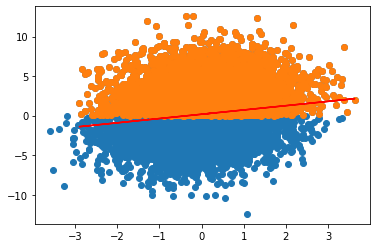

In [89]:
plt.scatter(X, noised)
plt.scatter(x_trunc, y_trunc)
plt.plot(x_trunc, x_trunc@w + w0, color='r')

In [61]:
data = Tensor(np.expand_dims(np.linspace(-3, 3), 1))

In [76]:
x_half, y_half = X[:5000], noised[:5000]

In [77]:
(x_half@w + w0 - y_half).var(0)

tensor([10.1086])

In [86]:
(x_trunc@w - y_trunc).var(0)

tensor([4.2200])

In [81]:
w0

tensor([[0.1702]])

In [24]:
rand = ch.randn(100, 16, 1)

In [25]:
rand > 0.0

tensor([[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [ True]],

        [[ True],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        [[ True],
         [False],
         [ True],
         ...,
         [ True],
         [False],
         [False]],

        ...,

        [[False],
         [ True],
         [False],
         ...,
         [False],
         [ True],
         [ True]],

        [[False],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        [[ True],
         [False],
         [ True],
         ...,
         [ True],
         [ True],
         [False]]])